In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = None

In [3]:
train_og = pd.read_csv('data/training_set_census.csv', skipinitialspace = True)
test_og = pd.read_csv('data/testing_set_census.csv', skipinitialspace = True)

In [4]:
train = train_og.copy()

In [5]:
test = test_og.copy()

In [6]:
print(train.shape)
test.shape

(200000, 42)


(50000, 41)

In [7]:
train.head(1)

,Unnamed: 0,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_labor_union,reason_for_unemployment,full_parttime_employment_stat,capital_gains,capital_losses,dividend_from_Stocks,tax_filer_status,region_of_previous_residence,state_of_previous_residence,d_household_family_stat,d_household_summary,migration_msa,migration_reg,migration_within_reg,live_1_year_ago,migration_sunbelt,num_person_Worked_employer,family_members_under_18,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,0,23,Private,43,22,Some college but no degree,0,College or university,Never married,Education,Adm support including clerical,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Single,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,NaN,NaN,Not in universe under 1 year old,NaN,4,Not in universe,Peru,Peru,United-States,Native- Born in the United States,0,Not in universe,2,30,95,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 42 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Unnamed: 0                        200000 non-null  int64 
 1   age                               200000 non-null  int64 
 2   class_of_worker                   200000 non-null  object
 3   industry_code                     200000 non-null  int64 
 4   occupation_code                   200000 non-null  int64 
 5   education                         200000 non-null  object
 6   wage_per_hour                     200000 non-null  int64 
 7   enrolled_in_edu_inst_lastwk       200000 non-null  object
 8   marital_status                    200000 non-null  object
 9   major_industry_code               200000 non-null  object
 10  major_occupation_code             200000 non-null  object
 11  race                              200000 non-null  object
 12  hi

In [9]:
train = train.replace('Not in universe',np.nan)
test = test.replace('Not in universe', np.nan)

In [10]:
train.isnull().sum()

Unnamed: 0                               0
age                                      0
class_of_worker                      99144
industry_code                            0
occupation_code                          0
education                                0
wage_per_hour                            0
enrolled_in_edu_inst_lastwk         187457
marital_status                           0
major_industry_code                      0
major_occupation_code                99570
race                                     0
hispanic_origin                        855
sex                                      0
member_of_labor_union               180812
reason_for_unemployment             193894
full_parttime_employment_stat            0
capital_gains                            0
capital_losses                           0
dividend_from_Stocks                     0
tax_filer_status                         0
region_of_previous_residence        184299
state_of_previous_residence         184776
d_household

# Data cleaning

In [11]:
# Columns to drop
def cols_deleted(a):
    cols_to_drop = ['Unnamed: 0','migration_sunbelt','state_of_previous_residence','region_of_previous_residence',
                    'year','member_of_labor_union','reason_for_unemployment','fill_questionnaire_veteran_admin',
                   'class_of_worker','family_members_under_18','enrolled_in_edu_inst_lastwk','major_occupation_code']
    a.drop(columns = cols_to_drop, inplace = True)
    return a

train = cols_deleted(train)
test = cols_deleted(test)

In [12]:
train.business_or_self_employed = train.business_or_self_employed.astype('str')
train.veterans_benefits = train.veterans_benefits.astype('str')

In [13]:
test.veterans_benefits = test.veterans_benefits.astype('str')
test.business_or_self_employed = test.business_or_self_employed.astype('str')

In [14]:
cols = train.columns.tolist()
cat_cols = train.select_dtypes(include = 'object').columns.to_list()
num_cols = train.select_dtypes(include = 'int64').columns.to_list()

In [15]:
for col in test.columns.tolist():
    if 'country' in col:
        test[col].fillna(test[col].mode()[0], inplace = True)

In [16]:
def hispanic_origin_clean(df):
    df.loc[(df.country_father == 'Cuba') | (df.country_mother == 'Cuba'),'hispanic_origin']='Cuban'
    df.loc[(df.country_father == 'Dominican-Republic') | (df.country_mother == 'Dominican-Republic'),'hispanic_origin']='Other Spanish'
    df.loc[(df.country_father == 'Haiti') | (df.country_mother == 'Haiti'),'hispanic_origin']='Other Spanish'
    df.loc[(df.country_father == 'Mexico') | (df.country_mother == 'Mexico'),'hispanic_origin']='Mexican (Mexicano)'
    df.hispanic_origin.fillna('All other', inplace = True)
    return df

train = hispanic_origin_clean(train)
test = hispanic_origin_clean(test)

### Changed hispanic origin for people whose parent's countries are any of the following:
### Puerto-rico, Mexico, Haiti, Dominican-Republican

In [17]:
def migration_data_cleaning(df):
    for col in df.columns.tolist():
        if 'migration' in col:
            df[col] = df[col].replace(['?',np.nan,'Not in universe'],'Nonmover')
    
    return df

train = migration_data_cleaning(train)
test = migration_data_cleaning(test)

In [18]:
train.dropna(subset = ['country_father','country_mother','country_self'], inplace = True)

# Data visualization

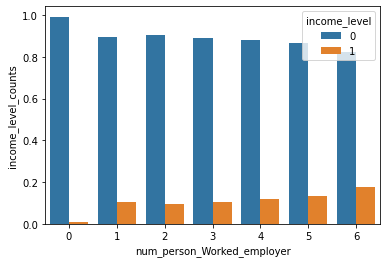

In [19]:
def bar_plot_visualize_income_level(column: str) -> None:
    bar_data = train.groupby(by = column)['income_level'].value_counts(normalize = True).to_frame()
    bar_data = bar_data.rename(columns = {'income_level' : 'income_level_counts'})
    bar_data = bar_data.reset_index()
    sns.barplot(data = bar_data, x = column, y = 'income_level_counts', hue = 'income_level')
    
bar_plot_visualize_income_level('num_person_Worked_employer')

<AxesSubplot:xlabel='income_level', ylabel='age'>

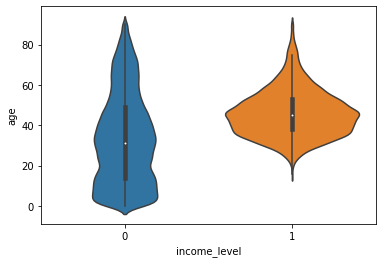

In [20]:
sns.violinplot(data = train, x = 'income_level', y = 'age')

<AxesSubplot:>

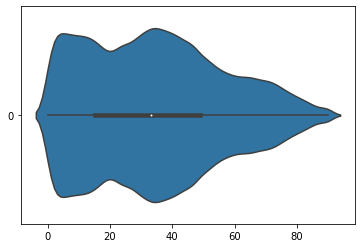

In [21]:
sns.violinplot(data = train['age'], orient = 'h')

# Data transformation

In [22]:
train_end = train.shape[0]
train_end

194387

In [23]:
y = train['income_level']
train.drop(columns = 'income_level', inplace = True)

In [24]:
full_df = pd.concat([train, test])
full_df.shape

(244387, 29)

In [28]:
full_df = pd.get_dummies(full_df, drop_first = True)

In [29]:
full_df.shape

(244387, 280)

In [30]:
train = full_df[:train_end]
test = full_df[train_end:]

In [31]:
train.shape

(194387, 280)

In [32]:
test.shape

(50000, 280)

# Feature engineering

<AxesSubplot:>

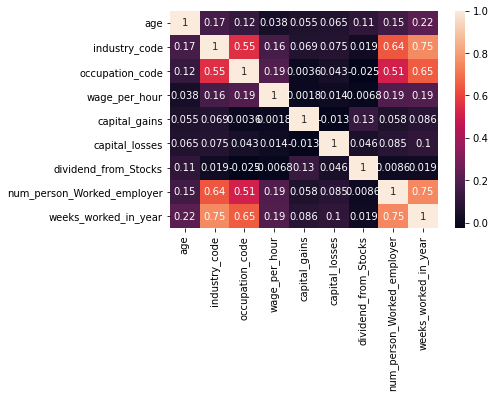

In [25]:
corr = train.corr()
sns.heatmap(corr, annot = True)

# Model training

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_scaled, y, test_size = 0.25, random_state = 42)

In [35]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [36]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(train_scaled, y)

SGDClassifier(random_state=42)

In [ ]:
lg_clf = LogisticRegression(random_state=42,max_iter = 250)
lg_clf.fit(train_scaled, y)

In [38]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_scaled, y)

RandomForestClassifier(random_state=42)

In [44]:
dt_clf = DecisionTreeClassifier(random_state = 42)
dt_clf.fit(train_scaled, y)

DecisionTreeClassifier(random_state=42)

In [65]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, x_train, y_train, cv = 3, scoring = 'accuracy')

array([0.90546742, 0.89147478, 0.89283069])

In [46]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(dt_clf, x_train, y_train, cv = 3)

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[129295,   5840],
       [  5276,   5379]], dtype=int64)

In [48]:
from sklearn.metrics import precision_score, recall_score
p = precision_score(y_train, y_train_pred)
r = recall_score(y_train, y_train_pred)


In [49]:
p

0.4794544968357251

In [50]:
r

0.5048334115438761

In [67]:
rf_pred = rf_clf.predict(test)

In [68]:
rf_pred.shape

(50000,)

In [69]:
rf_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [74]:
dt_pred = dt_clf.predict(test)

In [75]:
dt_pred.shape

(50000,)

In [57]:
type(rf_pred)

numpy.ndarray

In [76]:
dt_pred = pd.DataFrame(dt_pred, columns = ['prediction'])

In [78]:
dt_pred.to_csv('pred.csv', index = False)

In [77]:
dt_pred

,prediction
0,0
1,0
2,0
3,1
4,1
...,...
49995,0
49996,1
49997,0
49998,0
